In [1]:
!pip install torch numpy matplotlib

In [ ]:
# shakespeare.txt라는 데이터셋 다운받기
# 1.1MB, 약 100만 글자
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from collections import Counter
import time

# GPU 사용 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 디바이스: {device}')

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
np.random.seed(42)

사용 중인 디바이스: cpu


In [3]:
# 셰익스피어 텍스트를 인터넷에서 다운로드합니다
print("셰익스피어 텍스트 다운로드 중...")
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

print(f"다운로드 완료! 전체 텍스트 길이: {len(text):,} 글자")
print("\n텍스트 샘플:")
print(text[:500])  # 처음 500글자 출력

셰익스피어 텍스트 다운로드 중...
다운로드 완료! 전체 텍스트 길이: 1,115,394 글자

텍스트 샘플:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [4]:
class TextPreprocessor:
    """텍스트를 처리하고 숫자로 변환하는 클래스"""
    
    def __init__(self, text, seq_length=100):
        self.seq_length = seq_length
        
        # 고유한 문자들을 찾아서 정렬
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        # 문자 -> 숫자, 숫자 -> 문자 변환 사전
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        
        # 전체 텍스트를 숫자로 변환
        self.encoded_text = [self.char_to_idx[ch] for ch in text]
        
        print(f"어휘 크기: {self.vocab_size}개 문자")
        print(f"문자 목록: {''.join(self.chars[:20])}...")
        
    def encode(self, text):
        """텍스트를 숫자 리스트로 변환"""
        return [self.char_to_idx[ch] for ch in text if ch in self.char_to_idx]
    
    def decode(self, indices):
        """숫자 리스트를 텍스트로 변환"""
        return ''.join([self.idx_to_char[i] for i in indices])

# 전처리 객체 생성
preprocessor = TextPreprocessor(text, seq_length=100)

어휘 크기: 65개 문자
문자 목록: 
 !$&',-.3:;?ABCDEFG...


In [5]:
class ShakespeareDataset(Dataset):
    """PyTorch가 데이터를 읽을 수 있게 만드는 클래스"""
    
    def __init__(self, encoded_text, seq_length):
        self.encoded_text = encoded_text
        self.seq_length = seq_length
        
    def __len__(self):
        # 만들 수 있는 시퀀스의 개수
        return len(self.encoded_text) - self.seq_length
    
    def __getitem__(self, idx):
        # idx번째 시퀀스와 정답 가져오기
        # 입력: "Hell" → 정답: "ello"
        x = self.encoded_text[idx:idx + self.seq_length]
        y = self.encoded_text[idx + 1:idx + self.seq_length + 1]
        
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# 데이터셋과 데이터로더 생성
seq_length = 100  # 한 번에 학습할 문자 길이
batch_size = 64   # 한 번에 처리할 샘플 수

dataset = ShakespeareDataset(preprocessor.encoded_text, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"전체 학습 샘플 수: {len(dataset):,}개")
print(f"배치 수: {len(dataloader):,}개")

전체 학습 샘플 수: 1,115,294개
배치 수: 17,426개


In [6]:
class SimpleRNN(nn.Module):
    """기본적인 RNN 모델"""
    
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super(SimpleRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # 1. 임베딩 레이어: 숫자를 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 2. RNN 레이어: 순차적으로 정보 처리
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        
        # 3. 출력 레이어: 다음 문자 예측
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_length)
        
        # 임베딩 변환
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # RNN 처리
        output, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_length, hidden_dim)
        
        # 최종 예측
        output = self.fc(output)  # (batch_size, seq_length, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # 초기 은닉 상태 생성
        return torch.zeros(1, batch_size, self.hidden_dim).to(device)

# 모델 생성
rnn_model = SimpleRNN(preprocessor.vocab_size).to(device)
print(f"\n=== 간단한 RNN 모델 ===")
print(f"전체 파라미터 수: {sum(p.numel() for p in rnn_model.parameters()):,}개")


=== 간단한 RNN 모델 ===
전체 파라미터 수: 123,841개


In [7]:
class LSTMModel(nn.Module):
    """LSTM 모델 (장기 기억력이 더 좋음!)"""
    
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 2. LSTM 레이어: RNN보다 기억력이 좋음!
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # 3. 출력 레이어
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # 임베딩 변환
        embedded = self.embedding(x)
        
        # LSTM 처리
        output, hidden = self.lstm(embedded, hidden)
        
        # 최종 예측
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # LSTM은 두 개의 은닉 상태를 사용 (h, c)
        h0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

# 모델 생성
lstm_model = LSTMModel(preprocessor.vocab_size).to(device)
print(f"\n=== LSTM 모델 ===")
print(f"전체 파라미터 수: {sum(p.numel() for p in lstm_model.parameters()):,}개")


=== LSTM 모델 ===
전체 파라미터 수: 420,289개


In [8]:
def train_model(model, dataloader, epochs=10, model_name="Model"):
    """모델을 학습시키는 함수"""
    
    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()  # 분류 문제용 손실 함수
    optimizer = optim.Adam(model.parameters(), lr=0.002)  # Adam 최적화
    
    # 학습 기록용
    train_losses = []
    
    print(f"\n{'='*50}")
    print(f"{model_name} 학습 시작!")
    print(f"{'='*50}\n")
    
    model.train()  # 학습 모드
    
    for epoch in range(epochs):
        epoch_loss = 0
        start_time = time.time()
        
        for batch_idx, (x, y) in enumerate(dataloader):
            # 데이터를 GPU/CPU로 이동
            x, y = x.to(device), y.to(device)
            
            # 1. 기울기 초기화
            optimizer.zero_grad()
            
            # 2. 순전파 (Forward)
            output, _ = model(x)
            
            # 3. 손실 계산
            # output: (batch_size, seq_length, vocab_size)
            # y: (batch_size, seq_length)
            loss = criterion(output.view(-1, preprocessor.vocab_size), y.view(-1))
            
            # 4. 역전파 (Backward)
            loss.backward()
            
            # 5. 그래디언트 클리핑 (폭발 방지)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            
            # 6. 가중치 업데이트
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # 진행상황 출력
            if (batch_idx + 1) % 200 == 0:
                print(f"  배치 [{batch_idx+1}/{len(dataloader)}] - 손실: {loss.item():.4f}")
        
        # 에포크 평균 손실
        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        
        elapsed = time.time() - start_time
        print(f"\n에포크 [{epoch+1}/{epochs}] - 평균 손실: {avg_loss:.4f} - 소요시간: {elapsed:.1f}초\n")
    
    print(f"{model_name} 학습 완료! 🎉\n")
    return train_losses

In [9]:
def generate_text(model, start_string="The ", length=500, temperature=0.8):
    """학습된 모델로 새로운 텍스트 생성"""
    
    model.eval()  # 평가 모드
    
    # 시작 문자열을 숫자로 변환
    input_eval = preprocessor.encode(start_string)
    input_eval = torch.tensor(input_eval, dtype=torch.long).unsqueeze(0).to(device)
    
    # 생성된 텍스트 저장
    generated_text = start_string
    
    # 은닉 상태 초기화
    hidden = model.init_hidden(1)
    
    with torch.no_grad():  # 그래디언트 계산 안 함 (빠름!)
        for _ in range(length):
            # 예측
            output, hidden = model(input_eval, hidden)
            
            # 마지막 출력 가져오기
            output = output[0, -1, :] / temperature
            
            # 확률 분포로 변환
            probabilities = torch.softmax(output, dim=0).cpu().numpy()
            
            # 다음 문자 샘플링
            predicted_idx = np.random.choice(len(probabilities), p=probabilities)
            
            # 생성된 문자 추가
            generated_text += preprocessor.idx_to_char[predicted_idx]
            
            # 다음 입력 준비
            input_eval = torch.tensor([[predicted_idx]], dtype=torch.long).to(device)
    
    return generated_text

In [11]:
# RNN 학습 (10 에포크)
rnn_losses = train_model(rnn_model, dataloader, epochs=10, model_name="간단한 RNN")


간단한 RNN 학습 시작!

  배치 [200/17426] - 손실: 1.8033
  배치 [400/17426] - 손실: 1.6214
  배치 [600/17426] - 손실: 1.5465
  배치 [800/17426] - 손실: 1.5412
  배치 [1000/17426] - 손실: 1.5059
  배치 [1200/17426] - 손실: 1.4825
  배치 [1400/17426] - 손실: 1.4564
  배치 [1600/17426] - 손실: 1.4479
  배치 [1800/17426] - 손실: 1.4438
  배치 [2000/17426] - 손실: 1.3886
  배치 [2200/17426] - 손실: 1.4174
  배치 [2400/17426] - 손실: 1.4468
  배치 [2600/17426] - 손실: 1.4212
  배치 [2800/17426] - 손실: 1.3978


KeyboardInterrupt: 

In [ ]:
# LSTM 학습 (10 에포크)
lstm_losses = train_model(lstm_model, dataloader, epochs=10, model_name="LSTM")

In [ ]:
# 학습 과정 비교 그래프
plt.figure(figsize=(12, 6))

plt.plot(range(1, len(rnn_losses) + 1), rnn_losses, 'b-o', label='간단한 RNN', linewidth=2, markersize=8)
plt.plot(range(1, len(lstm_losses) + 1), lstm_losses, 'r-s', label='LSTM', linewidth=2, markersize=8)

plt.xlabel('에포크', fontsize=14)
plt.ylabel('평균 손실 (Loss)', fontsize=14)
plt.title('RNN vs LSTM 학습 곡선 비교', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 최종 손실 비교
print("\n" + "="*50)
print("최종 학습 결과 비교")
print("="*50)
print(f"RNN 최종 손실:  {rnn_losses[-1]:.4f}")
print(f"LSTM 최종 손실: {lstm_losses[-1]:.4f}")
print(f"개선율: {((rnn_losses[-1] - lstm_losses[-1]) / rnn_losses[-1] * 100):.2f}%")

plt.show()

In [ ]:
print("\n" + "="*70)
print("텍스트 생성 결과 비교")
print("="*70)

# 여러 시작 문자열로 테스트
start_strings = ["ROMEO:", "The King ", "To be or not to be"]

for start_str in start_strings:
    print(f"\n\n{'='*70}")
    print(f"시작 문자열: '{start_str}'")
    print(f"{'='*70}\n")
    
    # RNN 생성
    print("📝 간단한 RNN 생성:")
    print("-" * 70)
    rnn_text = generate_text(rnn_model, start_string=start_str, length=300, temperature=0.8)
    print(rnn_text)
    
    print("\n")
    
    # LSTM 생성
    print("📝 LSTM 생성:")
    print("-" * 70)
    lstm_text = generate_text(lstm_model, start_string=start_str, length=300, temperature=0.8)
    print(lstm_text)

In [ ]:
print("\n" + "="*70)
print("온도(Temperature)에 따른 생성 스타일 비교 (LSTM)")
print("="*70)

temperatures = [0.5, 0.8, 1.2]
start_string = "The "

for temp in temperatures:
    print(f"\n\n{'='*70}")
    print(f"온도: {temp} {'(보수적)' if temp < 0.7 else '(균형)' if temp < 1.0 else '(창의적)'}")
    print(f"{'='*70}\n")
    
    text = generate_text(lstm_model, start_string=start_string, length=300, temperature=temp)
    print(text)

NameError: name 'rnn_losses' is not defined

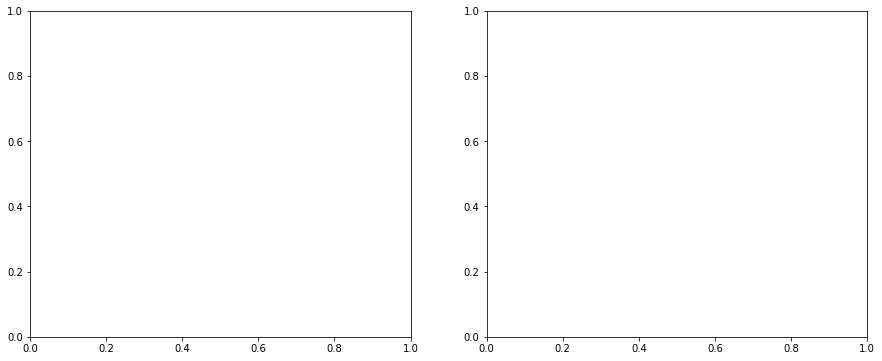

In [12]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Final loss comparison
ax1 = axes[0]
models = ['Simple RNN', 'LSTM']
final_losses = [rnn_losses[-1], lstm_losses[-1]]
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(models, final_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Final Loss (Lower is better)', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(final_losses) * 0.9, max(final_losses) * 1.1])

# Show value above bars
for bar, loss in zip(bars, final_losses):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{loss:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Parameter count comparison
ax2 = axes[1]
rnn_params = sum(p.numel() for p in rnn_model.parameters())
lstm_params = sum(p.numel() for p in lstm_model.parameters())
params = [rnn_params, lstm_params]

bars2 = ax2.bar(models, params, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Number of Parameters', fontsize=12)
ax2.set_title('Model Complexity Comparison', fontsize=14, fontweight='bold')

# Show value above bars
for bar, param in zip(bars2, params):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Final summary print
print("\n" + "="*70)
print("🎯 Final Project Summary")
print("="*70)
print(f"\n1. Data")
print(f"   - Number of training characters: {len(text):,}")
print(f"   - Vocabulary size: {preprocessor.vocab_size} unique characters")
print(f"   - Sequence length: {seq_length}")

print(f"\n2. Model Comparison")
print(f"   Simple RNN:")
print(f"   - Parameters: {rnn_params:,}")
print(f"   - Final Loss: {rnn_losses[-1]:.4f}")
print(f"   - Features: Simple structure, short-term memory")

print(f"\n   LSTM:")
print(f"   - Parameters: {lstm_params:,}")
print(f"   - Final Loss: {lstm_losses[-1]:.4f}")
print(f"   - Features: Gating mechanism, long-term memory")
print(f"   - Performance Improvement: {((rnn_losses[-1] - lstm_losses[-1]) / rnn_losses[-1] * 100):.2f}%")

print(f"\n3. Conclusion")
print(f"   ✅ LSTM learns long-term dependencies better")
print(f"   ✅ Generated text is more coherent and natural")
print(f"   ✅ Higher complexity, but clear performance gain")
print("\n" + "="*70)
